In [16]:
import os
import random
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
import textwrap
import progressbar as pb  # Use a different name for the progressbar module
import keras
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
from transformers import BertModel, BertConfig

import json

In [17]:
df = pd.read_csv('/Users/brundamariswamy/Downloads/ILDC_multi/ILDC_multi.csv') # path to multi_dataset
train_set = df.query(" split=='train' ")
test_set = df.query(" split=='test' ")
validation_set = df.query(" split=='dev' ")

In [18]:
from transformers import AutoTokenizer
import progressbar
from keras.preprocessing.sequence import pad_sequences

import progressbar

# With this import
from tqdm import tqdm

In [19]:
def tokenize_and_encode(dataf, tokenizer):
    input_ids = []
    lengths = []

    for i in tqdm(range(len(dataf['text']))):  # Use tqdm instead of progressbar
        sen = dataf['text'].iloc[i]
        sen = tokenizer.tokenize(sen)

        # taking the last 510 tokens
        # you can try out multiple combinations of input tokens as we did in the paper
        if len(sen) > 510:
            sen = sen[len(sen) - 510:]

        encoded_sent = tokenizer.encode(sen, add_special_tokens=True)
        input_ids.append(encoded_sent)
        lengths.append(len(encoded_sent))

    input_ids = pad_sequences(input_ids, maxlen=512, value=0, dtype="long", truncating="post", padding="post")
    return input_ids, lengths

In [20]:
model_checkpoint = "law-ai/CustomInLawBERT"

In [21]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_checkpoint, do_lower_case=True)
train_input_ids, train_lengths = tokenize_and_encode(train_set, tokenizer)
validation_input_ids, validation_lengths = tokenize_and_encode(validation_set, tokenizer)

100%|██████████| 994/994 [00:36<00:00, 27.28it/s]


In [22]:
def att_masking(input_ids):
  attention_masks = []
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)
  return attention_masks
train_attention_masks = att_masking(train_input_ids)
validation_attention_masks = att_masking(validation_input_ids)

In [25]:
train_labels = train_set['label'].to_numpy().astype('int')
validation_labels = validation_set['label'].to_numpy().astype('int')
train_inputs = train_input_ids
validation_inputs = validation_input_ids
train_masks = train_attention_masks
validation_masks = validation_attention_masks

In [26]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [27]:
batch_size = 6
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size = batch_size)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at law-ai/CustomInLawBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [29]:
lr = 2e-5
max_grad_norm = 1.0
epochs = 3
num_total_steps = len(train_dataloader)*epochs
num_warmup_steps = 1000
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=True)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_total_steps)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

seed_val = 34
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

/Users/brundamariswamy/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
loss_values = []


# For each epoch...
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 80 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1
        avg_eval_loss = eval_loss / len(validation_dataloader)
        

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy / nb_eval_steps))
   

print("")
print("Training complete!")

======== Epoch 1 / 3 ========
Training...
  Batch    80  of  5,385. 
  Batch   160  of  5,385. 
  Batch   240  of  5,385. 
  Batch   320  of  5,385. 
  Batch   400  of  5,385. 
  Batch   480  of  5,385. 
  Batch   560  of  5,385. 
  Batch   640  of  5,385. 
  Batch   720  of  5,385. 
  Batch   800  of  5,385. 
  Batch   880  of  5,385. 
  Batch   960  of  5,385. 
  Batch 1,040  of  5,385. 
  Batch 1,120  of  5,385. 
  Batch 1,200  of  5,385. 
  Batch 1,280  of  5,385. 
  Batch 1,360  of  5,385. 
  Batch 1,440  of  5,385. 
  Batch 1,520  of  5,385. 
  Batch 1,600  of  5,385. 
  Batch 1,680  of  5,385. 
  Batch 1,760  of  5,385. 
  Batch 1,840  of  5,385. 
  Batch 1,920  of  5,385. 
  Batch 2,000  of  5,385. 
  Batch 2,080  of  5,385. 
  Batch 2,160  of  5,385. 
  Batch 2,240  of  5,385. 
  Batch 2,320  of  5,385. 
  Batch 2,400  of  5,385. 
  Batch 2,480  of  5,385. 
  Batch 2,560  of  5,385. 
  Batch 2,640  of  5,385. 
  Batch 2,720  of  5,385. 
  Batch 2,800  of  5,385. 
  Batch 2,880

In [34]:
# Save the model
output_dir = '/Users/brundamariswamy/Desktop/Sentiment/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /Users/brundamariswamy/Desktop/Sentiment/


('/Users/brundamariswamy/Desktop/Sentiment/tokenizer_config.json',
 '/Users/brundamariswamy/Desktop/Sentiment/special_tokens_map.json',
 '/Users/brundamariswamy/Desktop/Sentiment/vocab.txt',
 '/Users/brundamariswamy/Desktop/Sentiment/added_tokens.json')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Training Loss Over Epochs
plt.figure(figsize=(6, 5))
plt.plot(range(1, epochs + 1), loss_values, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()


In [161]:
sentences = test_set.text

labels = test_set.label.to_numpy().astype(int)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    sent = tokenizer.tokenize(sent)
    # Remember to choose the same combination of input toks here
    if(len(sent) > 510):
      sent = sent[len(sent)-510:]
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=512, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 6  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [162]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []


# Predict 
for (step, batch) in enumerate(prediction_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  

  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,517 test sentences...
    DONE.


In [163]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [164]:
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_labels.flatten()

flat_accuracy(predictions,true_labels)



0.7270929466051417

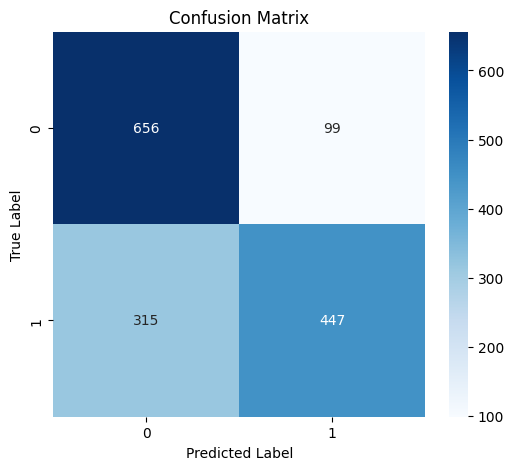

In [165]:
conf_mat = confusion_matrix(true_labels, pred_flat)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [104]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(labels_flat, pred_flat)

print(f'Matthews Correlation Coefficient: {mcc}')


Matthews Correlation Coefficient: 0.47448478891929574


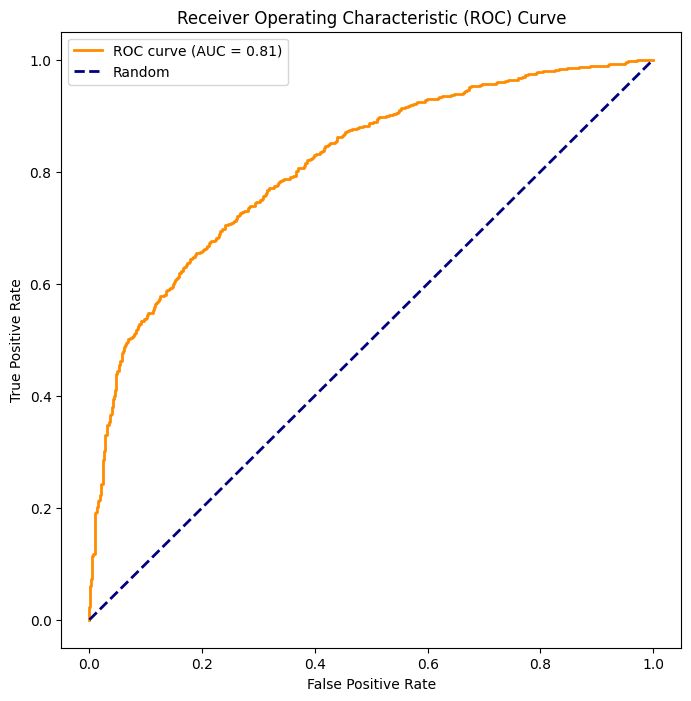

AUC-ROC: 0.81


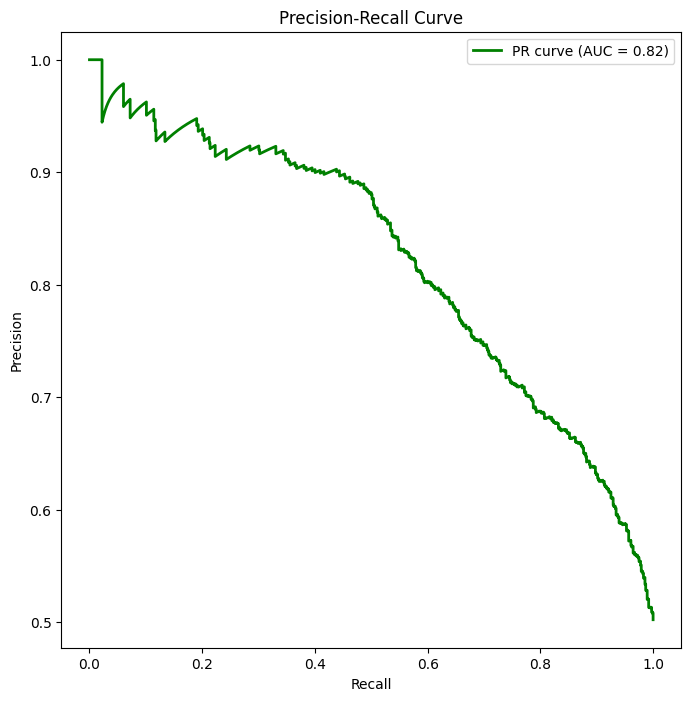

AUC-PR: 0.82


In [166]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score

# Assuming pred_probs contains probabilities for the positive class
precision, recall, _ = precision_recall_curve(labels_flat, predictions[:, 1])
pr_auc = auc(recall, precision)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels_flat, predictions[:, 1])
roc_auc = roc_auc_score(labels_flat, predictions[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print('AUC-ROC: {:.2f}'.format(roc_auc))

# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='green', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print('AUC-PR: {:.2f}'.format(pr_auc))


In [ ]:
# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='green', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print('AUC-PR: {:.2f}'.format(pr_auc))

In [150]:
import os
import random
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import textwrap
import progressbar
import keras
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random


In [151]:
# utility function to calculate metric scores
def metrics_calculator(preds, test_labels):
    cm = confusion_matrix(test_labels, preds)
    TP = []
    FP = []
    FN = []
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[i][j]

        FN.append(summ)
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[j][i]

        FP.append(summ)
    for i in range(0,2):
        TP.append(cm[i][i])
    precision = []
    recall = []
    for i in range(0,2):
        precision.append(TP[i]/(TP[i] + FP[i]))
        recall.append(TP[i]/(TP[i] + FN[i]))

    macro_precision = sum(precision)/2
    macro_recall = sum(recall)/2
    micro_precision = sum(TP)/(sum(TP) + sum(FP))
    micro_recall = sum(TP)/(sum(TP) + sum(FN))
    micro_f1 = (2*micro_precision*micro_recall)/(micro_precision + micro_recall)
    macro_f1 = (2*macro_precision*macro_recall)/(macro_precision + macro_recall)
    return macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1

macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1 = metrics_calculator(pred_flat, labels_flat)
print(macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1)


0.7471367458494131 0.7277441727068885 0.7373129669876355 0.7270929466051417 0.7270929466051417 0.7270929466051417


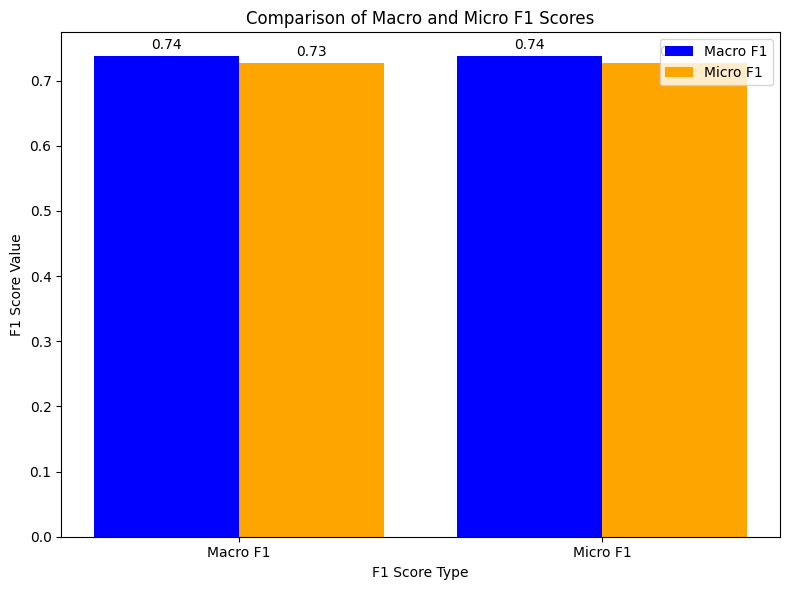

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have calculated F1 scores
macro_f1_scores = [macro_f1]
micro_f1_scores = [micro_f1]

labels = ['Macro F1', 'Micro F1']
x = np.arange(len(labels))
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, macro_f1_scores, width, label='Macro F1', color='blue')
rects2 = ax.bar(x + width/2, micro_f1_scores, width, label='Micro F1', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('F1 Score Type')
ax.set_ylabel('F1 Score Value')
ax.set_title('Comparison of Macro and Micro F1 Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Label with F1 Score value on top of the bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()

plt.show()


In [167]:


# Create sentence and label lists
sentences = validation_set.text

labels = validation_set.label.to_numpy().astype(int)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    sent = tokenizer.tokenize(sent)
    # Use the same input token combination here as well
    if len(sent) > 510:
       sent = sent[len(sent)-510:]
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=512, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 6  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [168]:
# Prediction on validation set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []


# Predict 
for (step, batch) in enumerate(prediction_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  

  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 994 test sentences...
    DONE.


In [169]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [170]:

predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

pred_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_labels.flatten()

flat_accuracy(predictions,true_labels)


0.7193158953722334

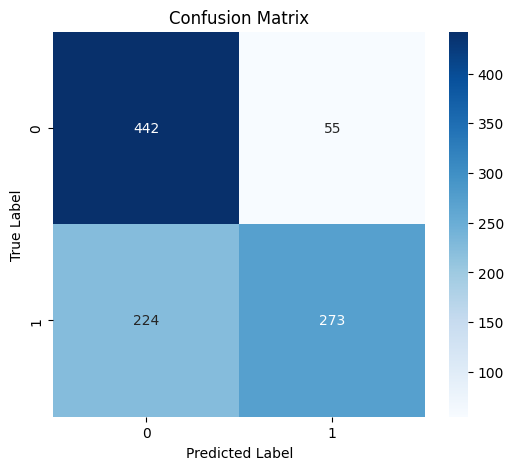

In [171]:
conf_mat = confusion_matrix(true_labels, pred_flat)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [124]:
import pandas as pd

# Assuming conf_mat is your confusion matrix
conf_mat_data = {'True Label': ['0', '1'],
                 'Predicted 0': [conf_mat[0, 0], conf_mat[1, 0]],
                 'Predicted 1': [conf_mat[0, 1], conf_mat[1, 1]]}

conf_mat_df = pd.DataFrame(conf_mat_data)
print("Confusion Matrix (Table Format):\n", conf_mat_df)


Confusion Matrix (Table Format):
   True Label  Predicted 0  Predicted 1
0          0          442           55
1          1          224          273


In [125]:
conf_mat1 = confusion_matrix(labels_flat, pred_flat)

# Calculate Matthews Correlation Coefficient
mcc1 = matthews_corrcoef(labels_flat, pred_flat)

print("Confusion Matrix:")
print(conf_mat1)
print("\nMatthews Correlation Coefficient:", mcc1)

Confusion Matrix:
[[442  55]
 [224 273]]

Matthews Correlation Coefficient: 0.4664256840831463


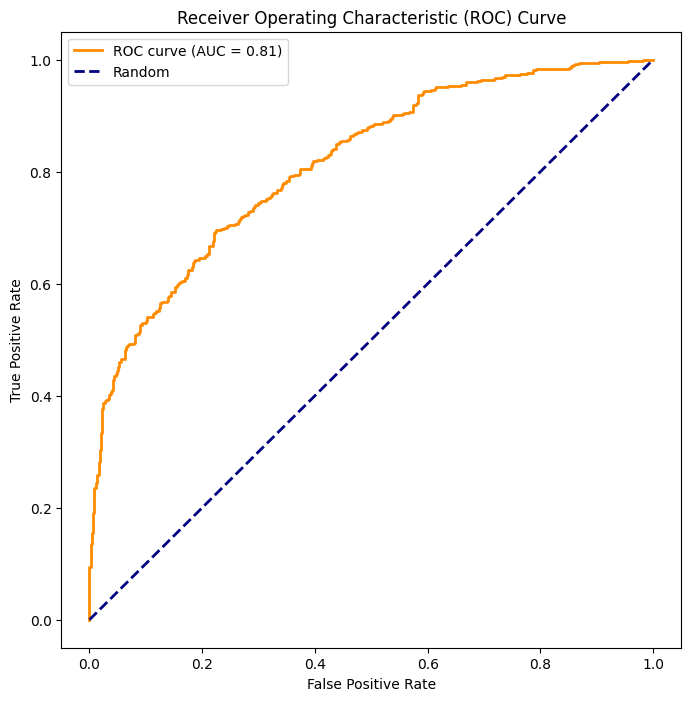

AUC-ROC: 0.81


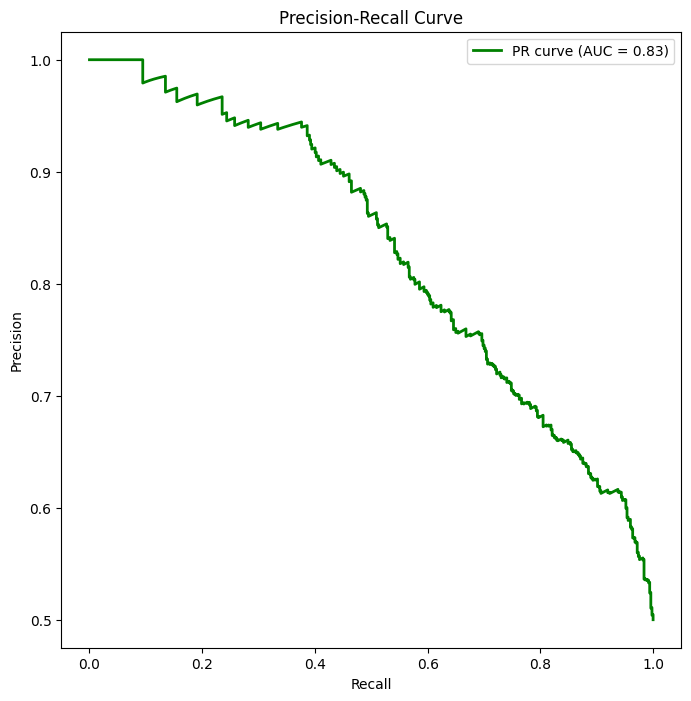

AUC-PR: 0.83


In [172]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score

# Assuming pred_probs contains probabilities for the positive class
precision, recall, _ = precision_recall_curve(labels_flat, predictions[:, 1])
pr_auc = auc(recall, precision)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels_flat, predictions[:, 1])
roc_auc = roc_auc_score(labels_flat, predictions[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print('AUC-ROC: {:.2f}'.format(roc_auc))

# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='green', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print('AUC-PR: {:.2f}'.format(pr_auc))


In [119]:
macro_precision,macro_recall, macro_f1, micro_precision, micro_recall, micro_f1 = metrics_calculator(pred_flat, labels_flat)
print(macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1)

0.7479903684171977 0.7193158953722334 0.7333729499638203 0.7193158953722334 0.7193158953722334 0.7193158953722335


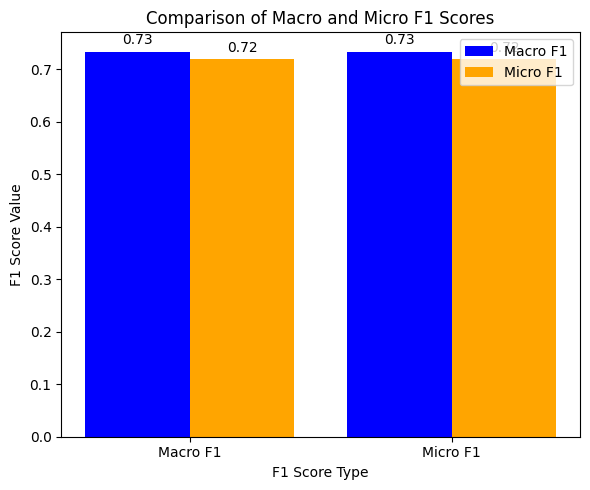

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have calculated F1 scores
macro_f1_scores = [macro_f1]
micro_f1_scores = [micro_f1]

labels = ['Macro F1', 'Micro F1']
x = np.arange(len(labels))
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 5))
rects1 = ax.bar(x - width/2, macro_f1_scores, width, label='Macro F1', color='blue')
rects2 = ax.bar(x + width/2, micro_f1_scores, width, label='Micro F1', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('F1 Score Type')
ax.set_ylabel('F1 Score Value')
ax.set_title('Comparison of Macro and Micro F1 Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Label with F1 Score value on top of the bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()

plt.show()
